#### Install MATES and required packages

In [ ]:
%%bash
# Clone the MATES repository
git clone https://github.com/mcgilldinglab/MATES.git

# Create a new environment
conda create -n mates_env python=3.9
conda activate mates_env

# Install required packages
conda install -c bioconda samtools -y
conda install -c bioconda bedtools -y

# Install MATES
cd MATES
pip install .
pip install velocyto # Required for intronic analysis

# Add environment to Jupyter Notebook
conda install ipykernel
python -m ipykernel install --user --name=mates_env

Cloning into 'MATES'...


In [1]:
import warnings
warnings.filterwarnings("ignore")

**Download the sample data to the same folder of this notebook.**

#### Build TE reference (this may takes a few minutes)

In [3]:
%%bash
python ../build_reference.py --species Mouse --intronic True

mm10.fa.out.gz already exists, skipping download and unzip.
gencode.vM10.annotation.gtf.gz already exists, skipping download and unzip.


#### Process aligned bam files

In [4]:
from MATES import bam_processor

In [ ]:
bam_processor.split_count_10X_data('exclusive', 'test_samplelist.txt', 'test_bam_path.txt',bc_ind = 'CR', bc_path_file='test_cb_path.txt',num_threads=2)

Directory ./file_tmp created.
Directory ./bam_tmp created.
Directory ./bc_tmp created.
Start splitting bam files into unique/multi reads sub-bam files ...
Directory ./unique_read created.
Directory ./multi_read created.
Finish splitting bam files into unique reads and multi reads sub-bam files.
Start splitting multi sub-bam based on cell barcodes...
Finish splitting unique sub-bam.
Finish splitting multi sub-bam.
Directory ./file_tmp removed.
Directory ./bam_tmp removed.
Directory ./bc_tmp removed.


#### Generate data for model

In [5]:
from MATES import data_processor

In [ ]:
data_processor.calculate_UM_region('exclusive', '10X', 'test_samplelist.txt', bin_size=5, proportion=80, ref_path = 'Default', bc_path_file='test_cb_path.txt')

Directory MU_Stats created.
Start Calculating U/M region for cells in test...


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 12.75it/s]

Finish calculating U/M region for cells in test, finalizing...
Finish finalizing U/M region information for test.


In [7]:
data_processor.generate_training_sample('10X', 'test_samplelist.txt', bin_size=5, proportion=80)

Start generating training sample for unqiue read TE in test...
Finish analyse generating sample for unqiue read TE in test.
Start generating training sample for multi read TE in test...
Finish analyse generating sample for multi read TE in test.
Finish Sample test


In [8]:
data_processor.generate_prediction_sample('exclusive', '10X', 'test_samplelist.txt', bin_size=5, proportion=80, ref_path = 'Default', bc_path_file='test_cb_path.txt')

Directory MU_Stats created.
Start analyse full prediciton data of multi read...


100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  4.36it/s]

(11445, 3)


100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.20it/s]

Finish analyse full prediciton data of multi read.
Finish saving data for prediction.


#### Training and prediction

In [9]:
from MATES import MATES_model

Data Mode:  10X
AE Settings:  Epoch:    150, Learning Rate: 0.000001
MLP Settings: Epoch:    150, Learning Rate: 0.000001
Batch Size:     36
Searching Bin Size:      5
Dominate Proportion:     80
Loading training data for test...
Training model for test...


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 20.33it/s]


Finish training model for test.


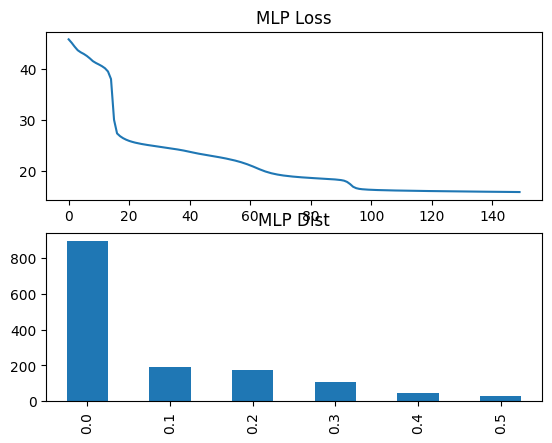

In [ ]:
MATES_model.train('10X', 'test_samplelist.txt', bin_size = 5, proportion = 80, BATCH_SIZE= 36, AE_LR = 1e-6, MLP_LR = 1e-6, AE_EPOCHS = 150, MLP_EPOCHS = 150,  DEVICE= 'cuda:0')

In [ ]:
MATES_model.prediction('exclusive', '10X', 'test_samplelist.txt', bin_size = 5, proportion = 80, AE_trained_epochs =150, MLP_trained_epochs=150,  DEVICE = 'cuda:0', ref_path = 'Default')

start calculating


 92%|███████████████████████████████████████▍   | 11/12 [00:00<00:00, 56.71it/s]


Finish quantify Multi TE


#### TE quantification

In [13]:
from MATES import TE_quantifier

In [14]:
TE_quantifier.unique_TE_MTX('exclusive', '10X', 'test_samplelist.txt', 1, ref_path = 'Default', bc_path_file='test_cb_path.txt')

 98%|█████████▊| 49/50 [00:48<00:00,  1.32it/s]

Combining batchly quntified Unique TE MTX...
Finish finalizing Unique TE MTX.


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


In [15]:
TE_quantifier.finalize_TE_MTX('10X', 'test_samplelist.txt')

Start create TE_MTX for test ...
Finish create TE_MTX for  test


#### Locus-level TE quantification

In [ ]:
MATES_model.prediction_locus('exclusive', '10X', 'test_samplelist.txt', bin_size=5, proportion=80, AE_trained_epochs=150, MLP_trained_epochs=150,  DEVICE= 'cuda:0', ref_path = 'Default')

In [16]:
TE_quantifier.quantify_locus_TE_MTX('exclusive', '10X', 'test_samplelist.txt')

Finish finalizing Unique TE MTX for test
Finalizing locus expression matrix for test...
Finis finalizing locus expression matrix for test.


#### Quantify intronic TE

In [1]:
from MATES import TE_quantifier_Intronic

In [2]:
#You can edit the path of gtf ('gencode.vM10.annotation.gtf') according to the location in your device
TE_quantifier_Intronic.implement_velocyto('10X', 1, 'test_samplelist.txt',  'test_bam_path.txt', 'gencode.vM10.annotation.gtf', bc_path_file='test_cb_path.txt')

Function parameters are valid. Proceeding with further implementation.
Directory ./file_tmp created or already exists.
Directory ./bam_tmp created or already exists.
Directory ./bc_tmp created or already exists.
Start running velocyto...
velocyto is already installed.
Directory test already exists.
Start Running Velocyto for test
/mnt/md0/ruohan/test2/MATES/example/test_cb.tsv
/mnt/md0/ruohan/test2/MATES/example/sample_data/sorted_final_merged.bam


/mnt/md0/ruohan/anaconda3/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/mnt/md0/ruohan/anaconda3/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/mnt/md0/ruohan/anaconda3/lib/py

End Running Velocyto for test
Finish running velocyto.
Directory ./file_tmp removed.
Directory ./bam_tmp removed.
Directory ./bc_tmp removed.


In [3]:
TE_quantifier_Intronic.parse_velocyto_output('10X', 1, 'test_samplelist.txt')

Directory ./file_tmp created or already exists.
Parsing output of velocyto for sample test


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]/mnt/md0/ruohan/anaconda3/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/mnt/md0/ruohan/anaconda3/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_

Directory ./file_tmp removed.


In [4]:
TE_quantifier_Intronic.count_unspliced_reads('10X', 1, 'test_samplelist.txt')

Start counting unspliced reads for test...


Processing pickle files: 100%|███████████████████| 1/1 [11:40<00:00, 700.15s/it]


Finished counting unspliced reads for test


In [5]:
TE_quantifier_Intronic.count_intornic_coverage_vec('10X', 5, 'test_samplelist.txt', ref_path='Default', bc_path_file='test_cb_path.txt')

Directory ./tmp created or already exists.
Directory ./count_coverage_intron created or already exists.
python /mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/MATES/scripts/count_coverage_10X.py test {i} 11 ./test_cb.tsv ./TE_intron.csv intronic
Finish batch 0:10/11 for sample test
Finish batch 0:11/11 for sample test
Finish batch 3:10/11 for sample test
Finish batch 3:11/11 for sample test
Finish batch 1:10/11 for sample test
Finish batch 1:11/11 for sample test
Finish batch 2:10/11 for sample test
Finish batch 2:11/11 for sample test
Directory ./tmp removed.


In [6]:
TE_quantifier_Intronic.generate_prediction_sample('10X', 'test_samplelist.txt', bin_size=5, proportion=80, ref_path = 'Default', bc_path_file='test_cb_path.txt')

Start analyse full prediciton data of multi read...


  0%|                                                     | 0/1 [00:00<?, ?it/s]

(0,)


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]

Finish analyse full prediciton data of multi read.
Finish saving data for prediction.


In [7]:
TE_quantifier_Intronic.quantify_U_TE_MTX('10X', 'test_samplelist.txt')

Finish finalizing Unique TE MTX for test


In [ ]:
TE_quantifier_Intronic.quantify_M_TE_MTX('10X', 'test_samplelist.txt', bin_size=5, proportion=80, AE_trained_epochs=150, MLP_trained_epochs=150,  DEVICE= 'cpu', ref_path = 'Default')


In [ ]:
TE_quantifier_Intronic.correct_intronic_TE('10X', 'test_samplelist.txt', ref_path = 'Default')